# ODI Data Processing
---
Glenn Abastillas | April 7, 2020

**Description** : Process and merge disparate sources of data for visualization in other notebooks.

In [143]:
from pathlib import Path
from glob import glob
from shapely import geometry
import missingno as msg
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import json

#### Define Data Folders and Paths

In [60]:
data = Path('../data')

datasets = data / 'datasets'
datasets_covid = [('regions', 'Regions_Covid', 'csv'), ('unicef', 'UNICEF GB', 'csv')]
datasets_demographics = [('socio-economic', 'SocioEconomic', 'csv'), ('population', 'population', 'csv')]
datasets_health = [('centers', 'healthcenters', 'csv'), ('food-security', 'FoodSecurity', 'csv'), ('sites', 'Healthsites', 'json')]

maps = data / 'maps'
maps_folders = ['health centers', 'regions', 'roads', 'schools', 'sectors']  # Excluding 'sanitary areas'
maps_subfolders = [maps / _ for _ in maps_folders]

#### Define Data Sources

In [72]:
# Helper functions to load string data
get_shp = lambda path_ : glob((path_ / '*.shp').as_posix())[0]
get_dat = lambda key, ext : glob((datasets / f'*{key}*{ext}').as_posix())[0]

# Shape Files for plotting map visualizations
shape_files = {folder.name : get_shp(folder) for folder in maps_subfolders}

# Data files to bind with Shape Files for visualizations
data_files = {
                'covid' : {name : get_dat(key, ext) for name, key, ext in datasets_covid},
                'demographics' : {name : get_dat(key, ext) for name, key, ext in datasets_demographics},
                'health' : {name : get_dat(key, ext) for name, key, ext in datasets_health},
             }

#### Load Data Sources

Load shape files

In [342]:
health_centers, regions, roads, schools, sectors = [gpd.read_file(shape_files[_]) for _ in maps_folders]

Load data frames

In [343]:
covid_regions, covid_unicef = [pd.read_csv(_) for _ in data_files['covid'].values()]
demographics_socioeconomic, demographics_population = [pd.read_csv(_) for _ in data_files['demographics'].values()]
health_centers_, health_foodsecurity = [pd.read_csv(_) for k, _ in data_files['health'].items() if k != 'sites']
# health_sites= pd.read_json(data_files['health']['sites'])

#### Inspect Maps

Summary
  * `region` and `roads` are readily mappable. 
  * `schools` has an issue with poorly mapped `long` values causing it to plot around the international date line.
  * `health_centers` requires you indicate `lat` and `long` appropriately if you read the `csv` data. Otherwise, shp plots correctly.
  * `health_sites` is lacking an `shx` file and will not load properly.
  
**Regions and Roads**

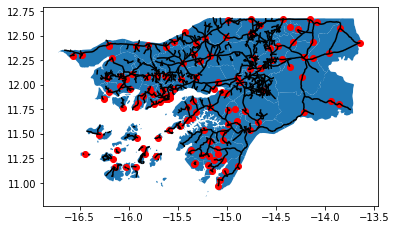

In [348]:
%matplotlib inline
fig, ax = plt.subplots()

# Region and roads are good to go
regions.plot(ax=ax); roads.plot(ax=ax, color='black'); health_centers.plot(ax=ax, color='red')

**Schools**

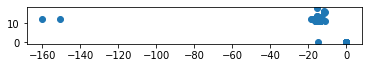

In [345]:
# Need to normalize schools data
schools.plot()

**Health Centers**

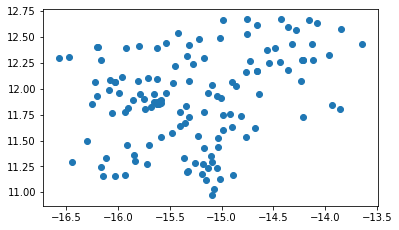

In [346]:
# Health centers does not plot well here, need to indicate to plot by 'lat' and 'long'
health_centers.plot()

For example:

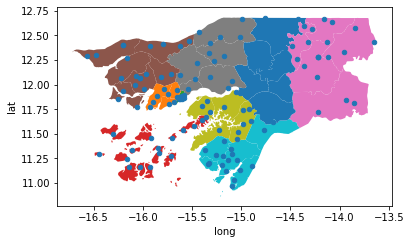

In [132]:
reg_ = regions.plot(column='ADM1_NAME')
health_centers.plot(x='long', y='lat', kind='scatter', ax=reg_)

#### Inspect Data Files

Summary
  * `covid_regions` has a lot of missing data.
  * `covid_unicef` contains the same columns as regions with no augmentation, use `covid_regions` instead of this data
  * `demographics_socioeconomics` there are a lot of indicators in this dataset that are need interpretation
  * `demographics_population` contains a lot of age and gender population data, melted data set to include age and gender as separate columns
  * `health_centers` contains good data about health centers and seems a duplicate of the SHP file
  * `health_foodsecurity` contains good data about food-related conditions but not by sector or region. Non-map visualizations best for this
  

**Covid Regions**

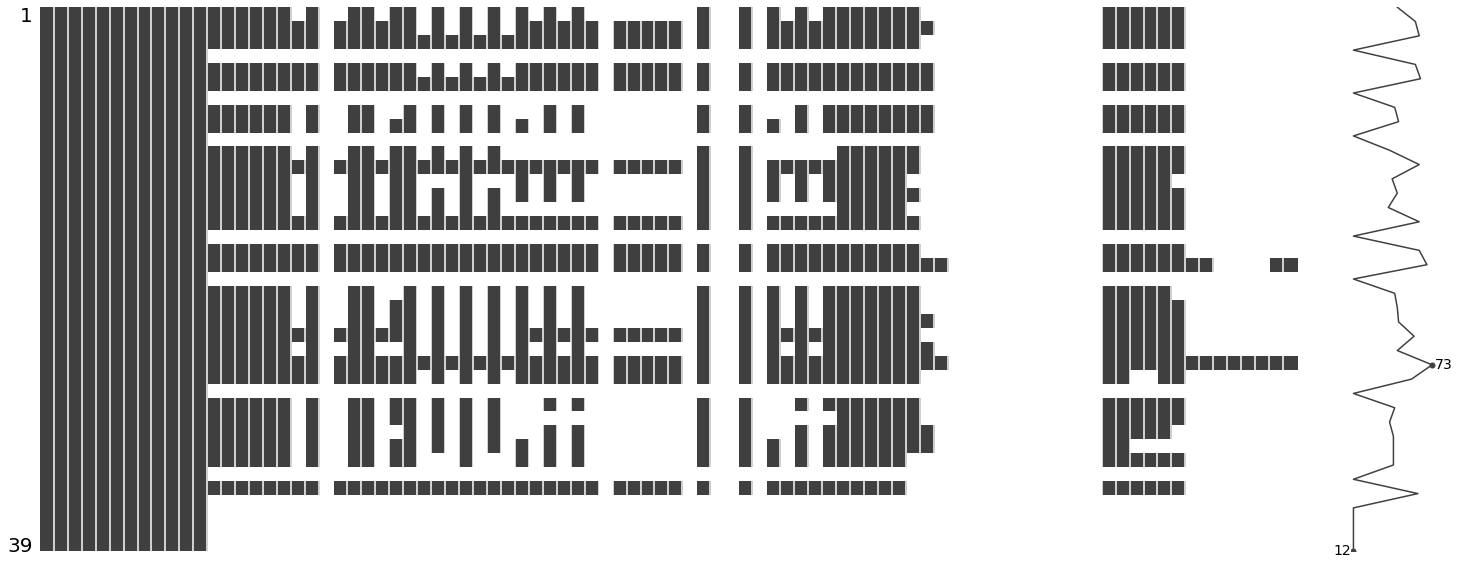

In [145]:
msg.matrix(covid_regions)

In [163]:
covid_regions_no_na = covid_regions.loc[:, covid_regions.isna().sum() < covid_regions.shape[0]]

In [164]:
covid_regions_no_na.columns

Index(['CNTRY_NAME', 'CNTRY_CODE', 'ADM1_NAME', 'ADM1_CODE', 'ADM2_NAME',
       'ADM2_CODE', 'RowcaCode1', 'RowcaCode2', 'HRname', 'HRpcode',
       'HRparent', 'geometry', 'rcode', 'hcf_name', 'reg_san', 'area_san',
       'cds_mwaterid', 'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins', 'waste_sharps',
       'waste_infect', 'jmp_cln_prot', 'jmp_cln_prot.1', 'jmp_hyg_svclvl.1',
       'jmp_hyg_avail.1', 'jmp_hyg_soap.1', 'handw_today_poc.1',
       'handw_today_toilet.1', 'watsys_exists', 'watsys_type',
       'watsys_tank_cap', 'watsys_tank_type', 'watsys_taps',
       '

In [165]:
covid_regions.watsys_taps_total.dtype

dtype('float64')

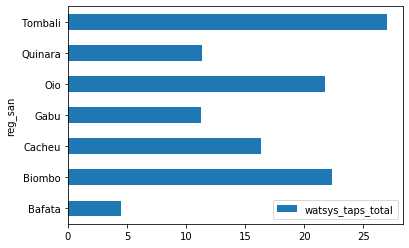

In [185]:
covid_regions_no_na.groupby('reg_san').mean().plot(kind='barh', y='watsys_taps_total')

Save modified file

In [186]:
covid_regions_no_na.to_csv(datasets / "covid_regions.csv")

**Covid UNICEF**

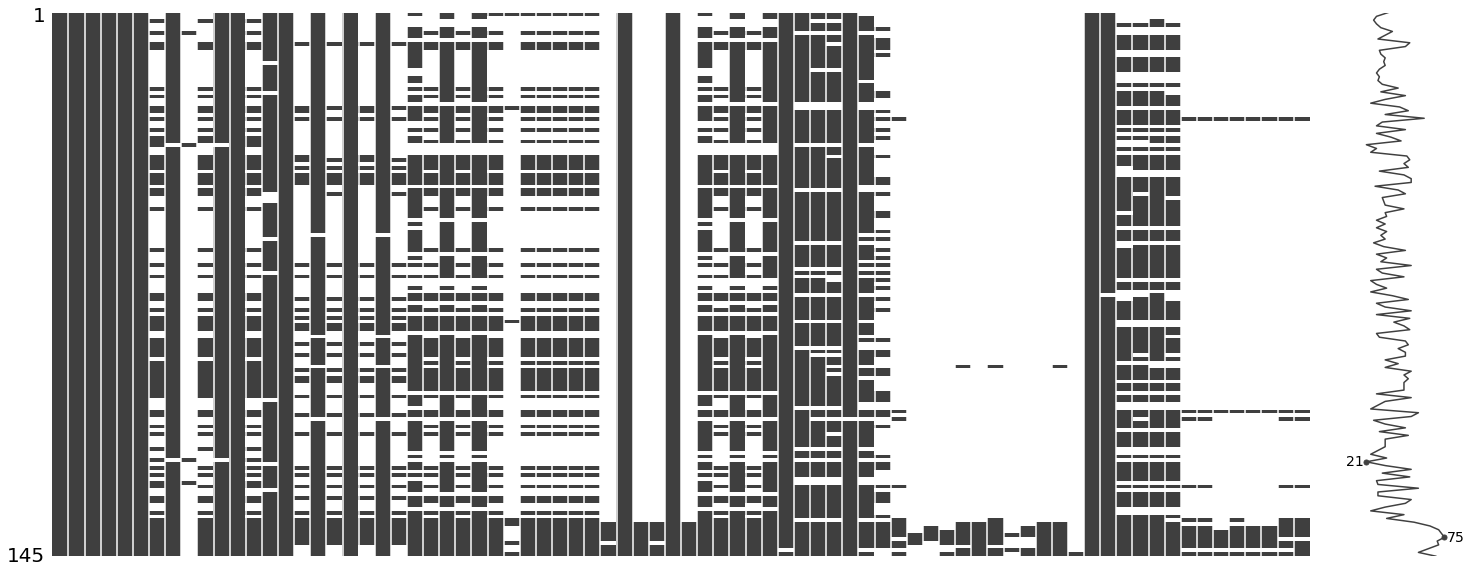

In [187]:
msg.matrix(covid_unicef)

In [188]:
covid_unicef.columns

Index(['rcode', 'hcf_name', 'reg_san', 'area_san', 'cds_mwaterid',
       'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp', 'jmp_wat_none',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_3bins', 'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins',
       'waste_sharps', 'waste_infect', 'jmp_cln_svclvl', 'jmp_cln_prot',
       'jmp_cln_staff', 'jmp_cln_svclvl.1', 'jmp_cln_prot.1',
       'jmp_cln_staff.1', 'jmp_hyg_svclvl.1', 'jmp_hyg_avail.1',
       'jmp_hyg_soap.1', 'handw_today_poc.1', 'handw_today_toilet.1',
       'watsys_exists', 'watsys_type', 'watsys_tank_cap', 'watsys_tank_type',
       'watsys_taps', 'watsys_taps_total', 'watsys_taps_func',
       'reh

In [191]:
covid_unicef_no_na = covid_unicef.loc[:, covid_unicef.isna().sum() < covid_unicef.shape[0]]

In [192]:
covid_unicef_no_na.columns

Index(['rcode', 'hcf_name', 'reg_san', 'area_san', 'cds_mwaterid',
       'submitted_date', 'jmp_wat_svclvl', 'jmp_wat_imp', 'jmp_wat_none',
       'jmp_wat_dist', 'wp_jmptype', 'water_available_today', 'wp_dist',
       'jmp_san_svclvl', 'jmp_san_usable', 'jmp_san_mhm', 'jmp_san_staff',
       'jmp_san_hcap', 'toilet_outpat', 'toilet_mhm', 'toilet_staff',
       'toilet_hcap', 'jmp_hyg_svclvl', 'jmp_hyg_avail', 'jmp_hyg_soap',
       'handw_today_poc', 'handw_today_toilet', 'jmp_waste_svclvl',
       'jmp_waste_3bins', 'jmp_waste_sharps', 'jmp_waste_inf', 'waste_3bins',
       'waste_sharps', 'waste_infect', 'jmp_cln_svclvl', 'jmp_cln_prot',
       'jmp_cln_staff', 'jmp_cln_svclvl.1', 'jmp_cln_prot.1',
       'jmp_cln_staff.1', 'jmp_hyg_svclvl.1', 'jmp_hyg_avail.1',
       'jmp_hyg_soap.1', 'handw_today_poc.1', 'handw_today_toilet.1',
       'watsys_exists', 'watsys_type', 'watsys_tank_cap', 'watsys_tank_type',
       'watsys_taps', 'watsys_taps_total', 'watsys_taps_func',
       'reh

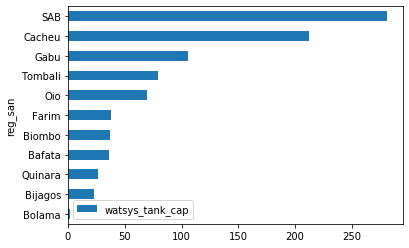

In [217]:
covid_unicef_no_na.groupby('reg_san').sum().sort_values('watsys_tank_cap').plot(kind='barh', y='watsys_tank_cap')


Check % overlap between covid datasets

In [208]:
unicef_in_regions = covid_unicef.columns.isin(covid_regions.columns)

overlap = round(100 * unicef_in_regions.sum() / covid_regions.columns.size)

print(f'Data overlap = {overlap}%\nUNICEF data has {covid_unicef.columns.size} columns\nRegions data has {covid_regions.columns.size} columns')
print(f'All of UNICEF data captured in Regions data? {unicef_in_regions.max()}')

Data overlap = 87.0%
UNICEF data has 78 columns
Regions data has 90 columns
All of UNICEF data captured in Regions data? True


Different columns are related to geoshape

In [222]:
covid_regions.columns[~covid_regions.columns.isin(covid_unicef.columns)]


Index(['CNTRY_NAME', 'CNTRY_CODE', 'ADM1_NAME', 'ADM1_CODE', 'ADM2_NAME',
       'ADM2_CODE', 'RowcaCode1', 'RowcaCode2', 'HRname', 'HRpcode',
       'HRparent', 'geometry'],
      dtype='object')

#### Demographics

**Socio-Economic**

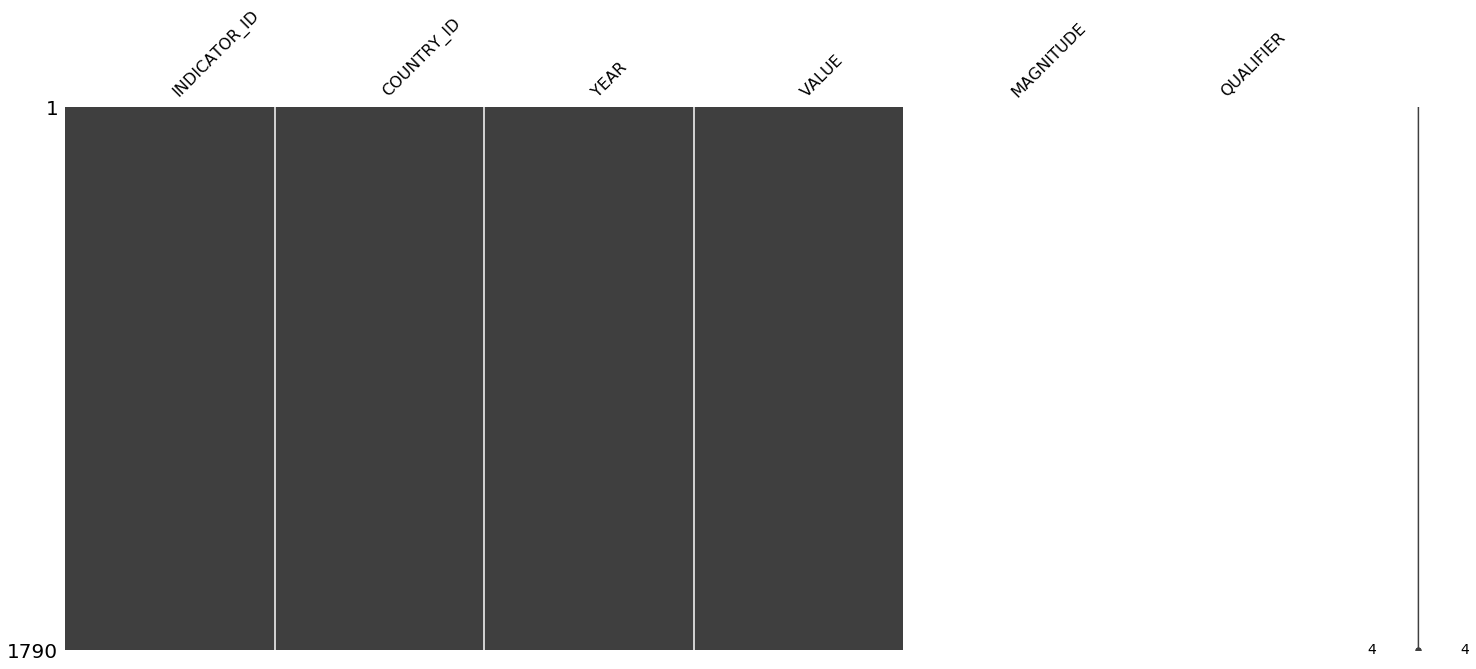

In [224]:
msg.matrix(demographics_socioeconomic)

In [229]:
demographics_socioeconomic.columns, demographics_socioeconomic.shape

(Index(['INDICATOR_ID', 'COUNTRY_ID', 'YEAR', 'VALUE', 'MAGNITUDE',
        'QUALIFIER'],
       dtype='object'), (1790, 6))

In [232]:
demographics_socioeconomic.sample(10)

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER
874,NY.GDP.DEFL.ZS,GNB,1996,31.52167,NaN,NaN
1249,ILO.LF.MF.15+.000,GNB,2014,717,NaN,NaN
1580,NY.GDP.PCAP.CD,GNB,1973,119.77683,NaN,NaN
195,NY.GNP.PCAP.PP.CD,GNB,2004,1140,NaN,NaN
407,SP.POP.GROW,GNB,1986,2.30748,NaN,NaN
379,NY.GDP.PCAP.CD,GNB,1979,153.00619,NaN,NaN
518,NY.GNP.PCAP.PP.CD,GNB,2005,1200.00000,NaN,NaN
494,SP.DYN.IMRT.IN,GNB,2018,54,NaN,NaN
559,DT.TDS.DECT.GN.ZS,GNB,1991,9.57446,NaN,NaN
746,NY.GDP.DEFL.ZS,GNB,1978,0.04444,NaN,NaN


Indicators, need to create a data dictionary for these.

In [231]:
demographics_socioeconomic.INDICATOR_ID.unique()

array(['#indicator+code', '200101', '200144', '200151', 'NY.GDP.MKTP.CN',
       'ILO.POP.F.15+.000', 'NY.GDP.MKTP.CD', 'NY.GDP.MKTP.KN',
       'PA.NUS.ATLS', 'SP.POP.GROW', 'SP.RUR.TOTL.ZS', 'ILO.ETPR.F.15+',
       'NY.GNP.MKTP.CN', 'NY.GDP.PCAP.PP.CD', 'ILO.EMP.MF.15+.000',
       'ILO.POP.MF.15+.000', 'SP.DYN.IMRT.IN', 'SH.DYN.AIDS.ZS',
       'NY.GNP.PCAP.CD', 'ILO.EMP.M.15+.000', 'PA.NUS.FCRF',
       'NY.GNP.PCAP.PP.CD', 'NY.GDP.DEFL.ZS', 'ILO.LF.F.15+.000',
       'SP.DYN.LE00.IN', 'NY.GDP.PCAP.CN', 'SI.POV.DDAY',
       'ILO.LFPR.MF.15+', 'ILO.LF.MF.15+.000', 'NY.GNP.PCAP.CN',
       'PA.NUS.PPPC.RF', 'NY.GDP.MKTP.KD', 'NY.GDP.MKTP.PP.CD',
       'NY.GDP.MKTP.PP.KD', 'ILO.LFPR.M.15+', 'NY.GDP.MKTP.KD.ZG',
       'ILO.ETPR.M.15+', 'ILO.LFPR.F.15+', 'PA.NUS.PPP', 'XTgov.IMF',
       'DT.TDS.DECT.GN.ZS', 'NY.GDP.PCAP.CD', 'NY.GDP.PCAP.PP.KD',
       'ILO.POP.M.15+.000', 'ILO.LF.M.15+.000', 'ILO.ETPR.MF.15+',
       'PA.NUS.PRVT.PP', 'SP.DYN.TFRT.IN', 'ILO.EMP.F.15+.000'],
      

**Population**

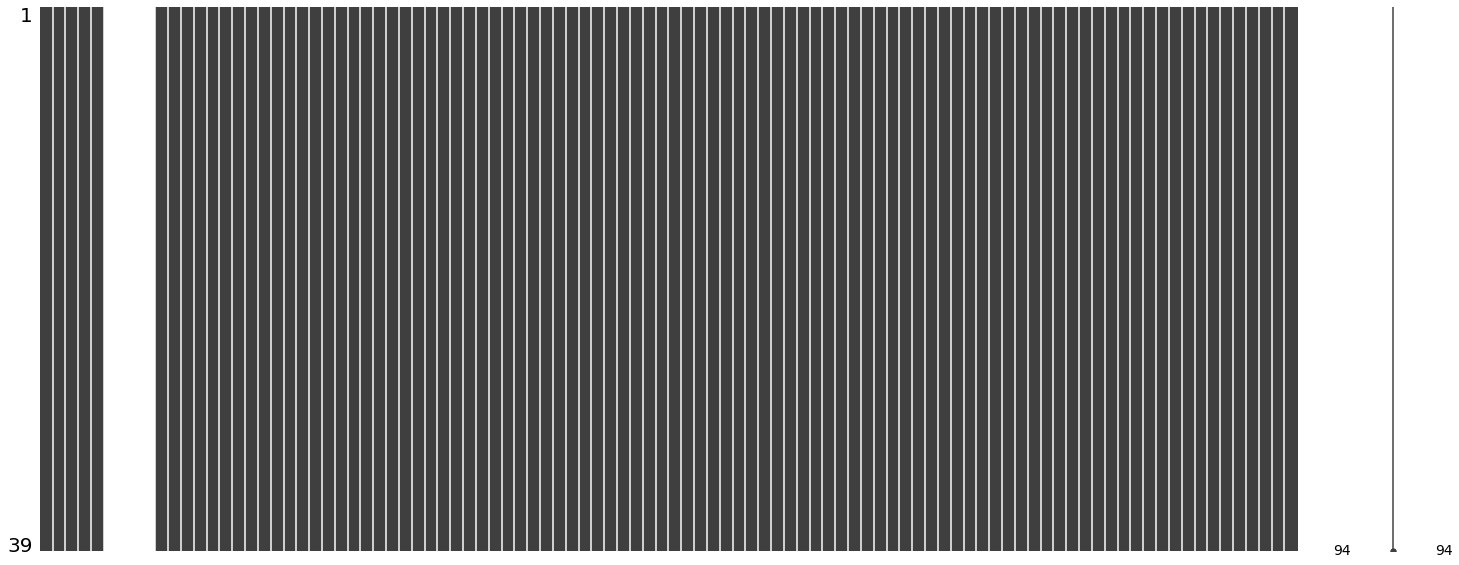

In [225]:
msg.matrix(demographics_population)

Extract age from demographics

In [233]:
demographics_population.columns

Index(['GUBID', 'ISOALPHA', 'COUNTRYNM', 'NAME1', 'NAME2', 'NAME3', 'NAME4',
       'NAME5', 'NAME6', 'CENTROID_X', 'CENTROID_Y', 'INSIDE_X', 'INSIDE_Y',
       'CONTEXT', 'CONTEXT_NM', 'WATER_CODE', 'TOTAL_A_KM', 'WATER_A_KM',
       'LAND_A_KM', 'UN_2000_E', 'UN_2005_E', 'UN_2010_E', 'UN_2015_E',
       'UN_2020_E', 'UN_2000_DS', 'UN_2005_DS', 'UN_2010_DS', 'UN_2015_DS',
       'UN_2020_DS', 'B_2010_E', 'F_2010_E', 'M_2010_E', 'A00_04B', 'A05_09B',
       'A10_14B', 'A15_19B', 'A20_24B', 'A25_29B', 'A30_34B', 'A35_39B',
       'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B', 'A65PLUSB',
       'A65_69B', 'A70PLUSB', 'A70_74B', 'A75PLUSB', 'A75_79B', 'A80PLUSB',
       'A80_84B', 'A85PLUSB', 'A00_04F', 'A05_09F', 'A10_14F', 'A15_19F',
       'A20_24F', 'A25_29F', 'A30_34F', 'A35_39F', 'A40_44F', 'A45_49F',
       'A50_54F', 'A55_59F', 'A60_64F', 'A65PLUSF', 'A65_69F', 'A70PLUSF',
       'A70_74F', 'A75PLUSF', 'A75_79F', 'A80PLUSF', 'A80_84F', 'A85PLUSF',
       'A00_04M', 'A05_0

In [310]:
melted = demographics_population.melt('NAME2')

In [312]:
demographics_age = melted.loc[(melted.variable.str.startswith("A")), :].groupby(['NAME2', 'variable']).sum().reset_index()

Augment data with extra columns

In [313]:
age_ = demographics_age.variable.str.replace(r"A(\d{2}).(\d+)\w", r'\1 to \2')
demographics_age['AGE'] = age_
demographics_age['AGE'] = demographics_age.AGE.str.replace(r"A(\d+)PLUS\w", r"\1 and older")
demographics_age['AGE_FROM'] = demographics_age.AGE.str.replace(r"^(\d+).*", r"\1")
demographics_age['AGE_TO'] = demographics_age.AGE.str.replace(r".*\s(\d+)$", r"\1")

gender_ = demographics_age.variable.str.replace(r"\w+(F)$", r"Female")
demographics_age['GENDER'] = gender_
demographics_age['GENDER'] = demographics_age.GENDER.str.replace(r"\w+(M)$", r"Male")
demographics_age['GENDER'] = demographics_age.GENDER.str.replace(r"\w+(B)$", r"All")

In [332]:
demographics_age.columns = ['ADM2_NAME', 'Age', 'Population', 'Age_Range', 'Age_From', 'Age_To', 'Gender']
demographics_age.Age_To = demographics_age.Age_To.str.replace(r"(NaN)", r'999')

In [333]:
demographics_age.Age_From = demographics_age.Age_From.astype('int')
demographics_age.Age_To = demographics_age.Age_To.astype('int')

In [334]:
demographics_age

,ADM2_NAME,Age,Population,Age_Range,Age_From,Age_To,Gender
0,Bafata,A00_04B,12605.883963,00 to 04,0,4,All
1,Bafata,A00_04F,6186.500610,00 to 04,0,4,Female
2,Bafata,A00_04M,6419.383353,00 to 04,0,4,Male
3,Bafata,A05_09B,11175.873672,05 to 09,5,9,All
4,Bafata,A05_09F,5541.050331,05 to 09,5,9,Female
...,...,...,...,...,...,...,...
2569,Xitole,A80_84F,0.000000,80 to 84,80,84,Female
2570,Xitole,A80_84M,0.000000,80 to 84,80,84,Male
2571,Xitole,A85PLUSB,0.000000,85 and older,85,999,All
2572,Xitole,A85PLUSF,0.000000,85 and older,85,999,Female


Save age demographic data

In [335]:
demographics_age.to_csv('../data/datasets/demographics_age_gender.csv', index=False)

**Health Centers**

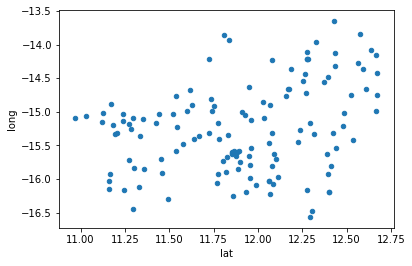

In [349]:
health_centers_.plot(kind='scatter', x='lat', y='long')

**Health Food Security**

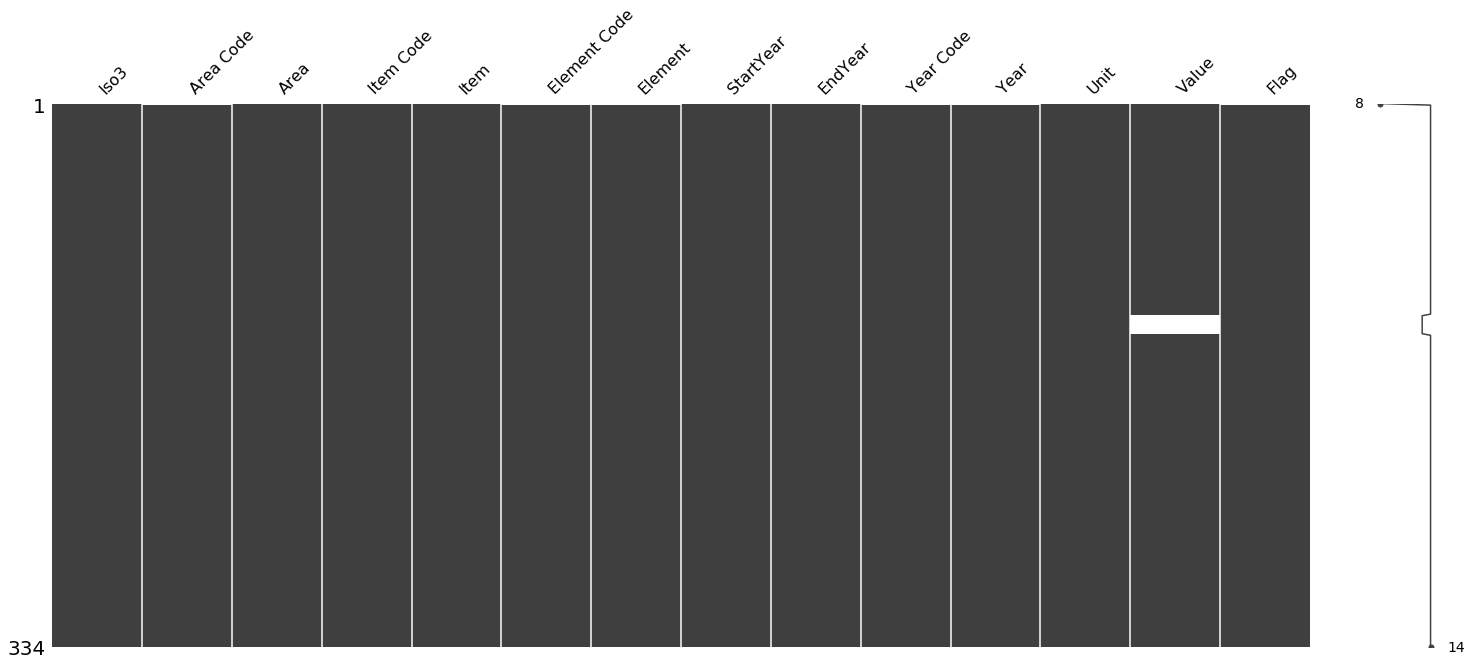

In [351]:
msg.matrix(health_foodsecurity)

In [355]:
health_foodsecurity.sample(5)

,Iso3,Area Code,Area,Item Code,Item,Element Code,Element,StartYear,EndYear,Year Code,Year,Unit,Value,Flag
314,GNB,175.0,Guinea-Bissau,21044,Prevalence of exclusive breastfeeding among in...,6121.0,Value,2000,2000,2000.0,2000,%,27.5,X
285,GNB,175.0,Guinea-Bissau,21042,Prevalence of obesity in the adult population ...,6121.0,Value,2005,2005,2005.0,2005,%,4.8,X
118,GNB,175.0,Guinea-Bissau,210011,Number of people undernourished (million) (3-y...,6132.0,Value,2005,2007,20052007.0,2005-2007,millions,0.3,F
246,GNB,175.0,Guinea-Bissau,21047,Percentage of population using at least basic ...,6121.0,Value,2014,2014,2014.0,2014,%,64.9,X
235,GNB,175.0,Guinea-Bissau,21047,Percentage of population using at least basic ...,6121.0,Value,2003,2003,2003.0,2003,%,55.9,X


In [353]:
health_foodsecurity.Item.unique()

array(['#indicator+name',
       'Average dietary energy supply adequacy (percent) (3-year average)',
       'Average value of food production (constant 2004-2006 I$/cap) (3-year average)',
       'Share of dietary energy supply derived from cereals, roots and tubers (kcal/cap/day) (3-year average)',
       'Average protein supply (g/cap/day) (3-year average)',
       'Average supply of protein of animal origin (g/cap/day) (3-year average)',
       'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)',
       'Prevalence of undernourishment (percent) (3-year average)',
       'Number of people undernourished (million) (3-year average)',
       'Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Number of severely food insecure people (million) (3-year average)',
       'Number of moderately or seve

In [ ]:
k